# Notebook Execution Guide

1. Activate the repo context (first code cell) to ensure `.venv` and `src/` imports.
2. Stage 1 (baseline/optimization) – run once per configuration.
3. Stage 2 (analysis and plots) – rerun freely after Stage 1 completes.
4. Stage 3 (exports or optional studies) – execute if you need derived artifacts.

Stick to Stage 1 before rerunning analysis when parameters change.


In [1]:
# Imports
from pathlib import Path
import sys

if '__file__' in globals():
    notebook_dir = Path(globals()['__file__']).resolve().parent
else:
    notebook_dir = Path.cwd()
repo_root_guess = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
if str(repo_root_guess) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root_guess))

from src.notebook_setup import activate_repository

repo_root = activate_repository(context=globals())

from src import TimeGridSpec, PulseShapeSpec, BasisSpec
from src import override_from_dict, run_experiment
from src.notebook_runners import build_base_config, method_options, prepare_baseline



In [3]:
# Experiment configuration inputs
# Baseline grid/shape parameters
time_grid_params = {
    'duration_us': 0.1,
    'num_points': 2000,
    'start_us': 0.0,
}
omega_shape = {'kind': 'polynomial', 'area_pi': 4.0}
delta_shape = {'kind': 'polynomial_chirp', 'area_pi': 0.0, 'amplitude_scale': 150.0}
K_omega = 8
K_delta = 4

# Optional state / pulse seeds (set to None to use defaults)
rho0 = [[1.0, 0.0], [0.0, 0.0]]
target = [[0.0, 0.0], [0.0, 1.0]]
initial_omega = None
initial_delta = None

# Optimizer stopping criteria
max_time_min = 10.0  # per optimizer runtime budget in minutes
max_iters = 2000
grad_tol = -1e-12
rtol = -1e-12

# Method-specific hyperparameters
const_learning_rate = 0.5
alpha0 = 10.0*(2**6)
ls_beta = 0.5
ls_sigma = 1e-4
ls_max_backtracks = 30
adam_learning_rate = 0.5
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay_default = 0.9992

# Penalty weights for Stage 1
power_weight = 1.0e-8
neg_weight = 1.0e-8
neg_kappa = 10.0

# Artifact/output configuration
artifact_root = Path('./artifacts')
run_name = 'stepsize-comparison'
objective = 'path'
print(time_grid_params['duration_us']/time_grid_params['num_points'])


5e-05


# Execution order
# Stage 1: baseline + optimization (run once)
# Stage 2: analysis/plots (safe to rerun)
# Stage 3: exports (optional)

In [10]:
# Analysis helpers
import csv
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np

from src.analysis import (
    ResultSummary,
    TrajectoryBundle,
    TrajectoryRequest,
    compute_bloch_bundle,
    render_step_size_dashboard,
    summarize_result,
)
from src.analysis.plots import (
    plot_cost_components,
    plot_cost_histories,
    plot_population_traces,
    plot_pulse_overlay,
    render_summary_table,
    save_figure,
)

RUN_METHODS = ('const', 'linesearch', 'adam')


## Run optimizers

In [11]:
# Run all (const, linesearch, adam)
time_grid_cfg = globals().get('time_grid_params')
runner_ctx = prepare_baseline(
    time_grid=time_grid_cfg,
    omega_shape=omega_shape,
    delta_shape=delta_shape,
    K_omega=K_omega,
    K_delta=K_delta,
    rho0=globals().get('rho0'),
    target=globals().get('target'),
    initial_omega=globals().get('initial_omega'),
    initial_delta=globals().get('initial_delta'),
)

penalties = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}
base_config, base_opts = build_base_config(
    runner_ctx.config,
    run_name=run_name,
    artifact_root=artifact_root,
    penalties=penalties,
    objective=objective,
    base_optimizer_options={
        'max_iters': int(max_iters),
        'grad_tol': float(grad_tol),
        'rtol': float(rtol),
        'max_time_s': float(max_time_min) * 60.0,
        'optimize_delta': bool(K_delta > 0),
    },
)

method_overrides = {
    'const': {
        'learning_rate': float(const_learning_rate),
        'lr_decay': float(lr_decay_default)
    },
    'linesearch': {
        'alpha0': float(alpha0),
        'ls_beta': float(ls_beta),
        'ls_sigma': float(ls_sigma),
        'ls_max_backtracks': int(ls_max_backtracks),
    },
    'adam': {
        'learning_rate': float(adam_learning_rate),
        'beta1': float(beta1),
        'beta2': float(beta2),
        'epsilon': float(epsilon),
        'lr_decay': float(lr_decay_default),
    },
}

results: Dict[str, ResultSummary] = {}
bloch_data: Dict[str, Dict[str, TrajectoryBundle]] = {}

trajectory_base = TrajectoryRequest(
    psi0=runner_ctx.psi0,
    dt_us=runner_ctx.dt_us,
    omega_base=runner_ctx.arrays['Omega0'],
    delta_base=runner_ctx.arrays.get('Delta0'),
)

for method in RUN_METHODS:
    print(f'[{method}] starting optimization')
    try:
        overrides = method_overrides.get(method, {})
        opts = method_options(method, base_opts, overrides)
        config = override_from_dict(base_config, {'optimizer_options': opts})
        result = run_experiment(
            config,
            method=method,
            run_name=f'{run_name}-{method}',
            exist_ok=True,
        )
        summary = summarize_result(result)
        results[method] = summary
        bloch_data[method] = compute_bloch_bundle(summary, trajectory_base, include_baseline=True)
        print(f'[{method}] finished optimization (status={summary.status})')
    except Exception as exc:  # noqa: BLE001
        print(f'[{method}] error: {exc}')

if not results:
    raise RuntimeError('All optimizations failed; inspect logs above.')


[const] starting optimization
[const] finished optimization (status=max_iters)
[linesearch] starting optimization
[linesearch] finished optimization (status=max_iters)
[adam] starting optimization
[adam] finished optimization (status=max_iters)


## Results summary

In [12]:
# Results summary (no plots)
if not results:
    raise RuntimeError("Run the optimizer cell first.")

header = (
    f"{'method':>10}  {'total':>12}  {'terminal':>12}  {'power':>10}  "
    f"{'neg':>10}  {'iters':>8}  {'runtime_s':>10}  {'oracle':>8}  "
    f"{'max|Omega|':>10}  {'area/pi':>10}  {'neg_frac':>10}"
)
print(header)
rows = []
for method in RUN_METHODS:
    summary = results.get(method)
    if summary is None:
        continue
    metrics = summary.metrics
    row = {
        "method": method,
        "total_final": float(metrics.get("total", np.nan)),
        "terminal_final": float(metrics.get("terminal", np.nan)),
        "power_final": float(metrics.get("power_penalty", 0.0)),
        "neg_final": float(metrics.get("neg_penalty", 0.0)),
        "iterations": int(summary.iterations),
        "runtime_s": float(summary.runtime_s),
        "oracle_calls": int(summary.oracle_calls),
        "max_abs_omega": float(summary.max_abs_omega),
        "area_omega_over_pi": float(summary.area_omega_over_pi),
        "negativity_fraction": float(summary.negativity_fraction),
    }
    rows.append(row)
    line = (
        f"{method:>10}  {row['total_final']:12.5e}  {row['terminal_final']:12.5e}  "
        f"{row['power_final']:10.3e}  {row['neg_final']:10.3e}  {row['iterations']:8d}  "
        f"{row['runtime_s']:10.3f}  {row['oracle_calls']:8d}  {row['max_abs_omega']:10.3f}  "
        f"{row['area_omega_over_pi']:10.3f}  {row['negativity_fraction']:10.3f}"
    )
    print(line)

summary_fields = [
    "method",
    "total_final",
    "terminal_final",
    "power_final",
    "neg_final",
    "iterations",
    "runtime_s",
    "oracle_calls",
    "max_abs_omega",
    "area_omega_over_pi",
    "negativity_fraction",
]
summary_dir = (Path(artifact_root) / run_name).resolve()
summary_dir.mkdir(parents=True, exist_ok=True)
csv_path = summary_dir / "summary.csv"
with csv_path.open("w", newline="", encoding="utf-8") as fh:
    writer = csv.DictWriter(fh, fieldnames=summary_fields)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

print(f"Summary written to {csv_path}")


    method         total      terminal       power         neg     iters   runtime_s    oracle  max|Omega|     area/pi    neg_frac
     const   1.77855e-02   2.10159e-03   3.168e-05   2.351e-05      2000     148.106      2000     196.232       4.145       0.000
linesearch   1.32646e-02   6.10248e-04   3.308e-05   2.750e-05      2000     316.260      6054     205.276       4.101       0.000
      adam   4.82251e-03   7.10224e-05   6.097e-05   1.489e-04      2000     156.909      2000     242.637       4.386       0.088
Summary written to /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/summary.csv


## Figure Plan
- Cost vs iteration (log scale) for const, linesearch, adam.
- Cost-term breakdown (terminal, power, neg) vs iteration (log scale).
- Runtime (s) bar chart and oracle-call bar chart.
- Ω(t) and Δ(t) overlays: initial pulse plus finals (skip Δ if not optimised).
- Excited-state population vs time for each final control.
- Bloch-sphere trajectories: baseline and each method with instantaneous ground-state path.
- Save figures to rtifacts/<run_name>/figures/ with required filenames.


Saved figures:
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/delta_pulses.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/neg_penalty_vs_iter.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/omega_pulses.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/oracle_calls_by_method.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/power_penalty_vs_iter.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/runtime_by_method.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/summary_table.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/terminal_infidelity_vs_iter.png
 - /home/yehon/projects/grape-crab-qoc/artifacts/stepsize-comparison/figures/total_cost_vs_iter.png


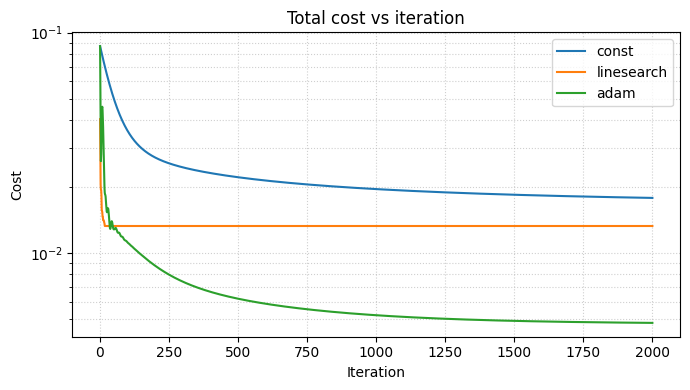

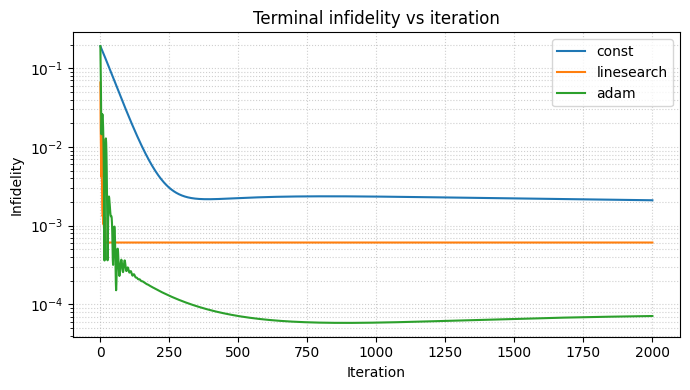

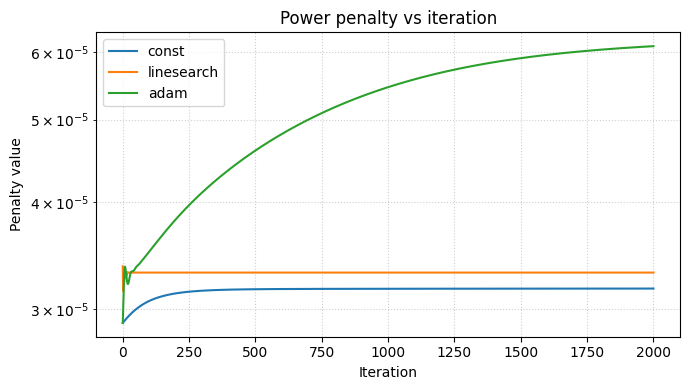

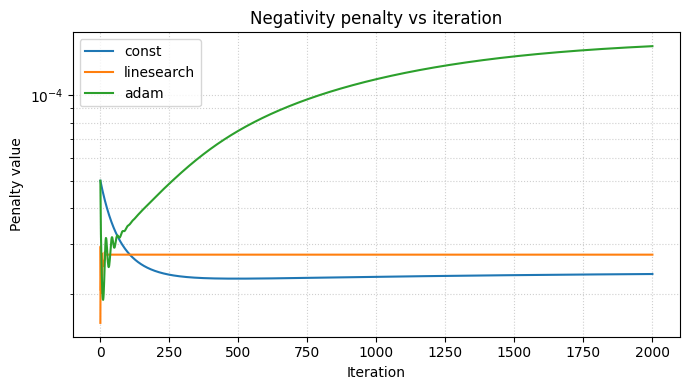

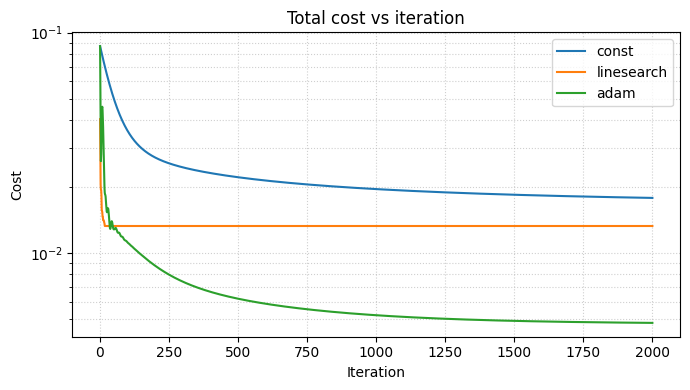

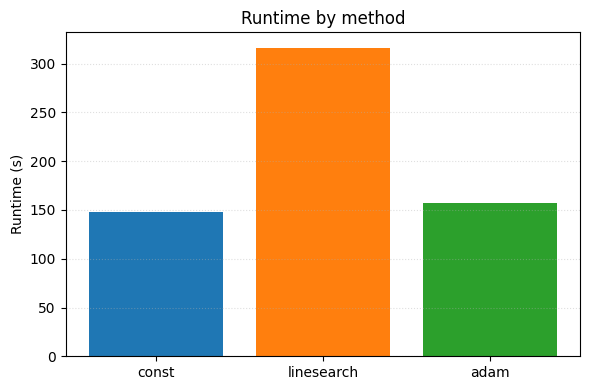

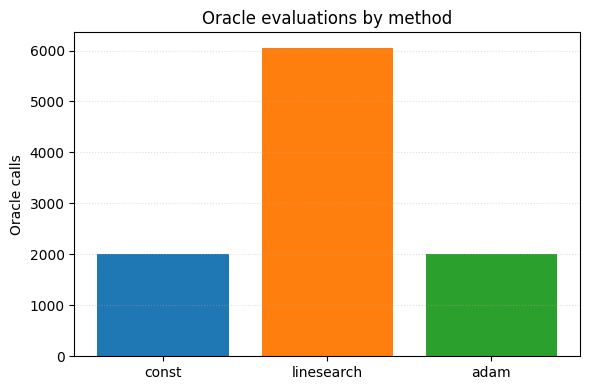

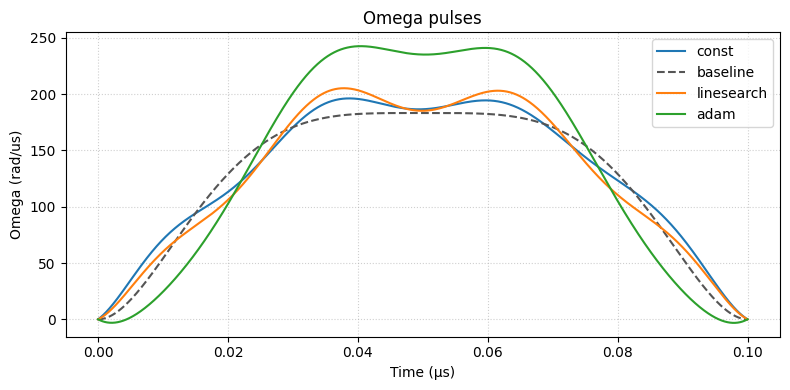

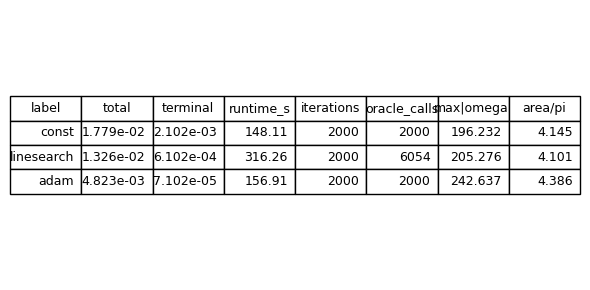

In [13]:
# Figures
if not results:
    raise RuntimeError('Run the optimizer cell first.')

labels = [method for method in RUN_METHODS if method in results]
summary_list = [results[label] for label in labels]

fig_dir = (Path(artifact_root) / run_name / 'figures').resolve()
fig_dir.mkdir(parents=True, exist_ok=True)
# Cost component trajectories
component_specs = [
    ('total', 'Total cost vs iteration', 'total_cost_vs_iter', 'Cost'),
    ('terminal', 'Terminal infidelity vs iteration', 'terminal_infidelity_vs_iter', 'Infidelity'),
    ('power_penalty', 'Power penalty vs iteration', 'power_penalty_vs_iter', 'Penalty value'),
    ('neg_penalty', 'Negativity penalty vs iteration', 'neg_penalty_vs_iter', 'Penalty value'),
]

for key, title, stem, ylabel in component_specs:
    fig_comp, ax_comp = plt.subplots(figsize=(7, 4))
    plotted = False
    for label, summary in zip(labels, summary_list):
        history = summary.history
        series = getattr(history, key)
        if series is None or series.size == 0:
            continue
        iterations = history.iterations
        if iterations is None or iterations.size != series.size:
            iterations = np.arange(1, series.size + 1, dtype=np.int64)
        ax_comp.semilogy(iterations, series, label=label)
        plotted = True
    if not plotted:
        plt.close(fig_comp)
        continue
    ax_comp.set_xlabel('Iteration')
    ax_comp.set_ylabel(ylabel)
    ax_comp.set_title(title)
    ax_comp.grid(True, which='both', ls=':', alpha=0.6)
    ax_comp.legend()
    fig_comp.tight_layout()
    save_figure(fig_comp, fig_dir, stem, save_svg=True)


# Total cost history
fig_cost, ax_cost = plt.subplots(figsize=(7, 4))
plot_cost_histories(summary_list, ax=ax_cost, labels=labels)
save_figure(fig_cost, fig_dir, 'total_cost_vs_iter', save_svg=True)

# Runtime bar plot
fig_runtime, ax_runtime = plt.subplots(figsize=(6, 4))
runtime_values = [summary.runtime_s for summary in summary_list]
ax_runtime.bar(labels, runtime_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'][: len(labels)])
ax_runtime.set_ylabel('Runtime (s)')
ax_runtime.set_title('Runtime by method')
ax_runtime.grid(True, axis='y', ls=':', alpha=0.4)
fig_runtime.tight_layout()
save_figure(fig_runtime, fig_dir, 'runtime_by_method', save_svg=True)

# Oracle bar plot
fig_oracle, ax_oracle = plt.subplots(figsize=(6, 4))
oracle_values = [summary.oracle_calls for summary in summary_list]
ax_oracle.bar(labels, oracle_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'][: len(labels)])
ax_oracle.set_ylabel('Oracle calls')
ax_oracle.set_title('Oracle evaluations by method')
ax_oracle.grid(True, axis='y', ls=':', alpha=0.4)
fig_oracle.tight_layout()
save_figure(fig_oracle, fig_dir, 'oracle_calls_by_method', save_svg=True)

# Omega pulses
fig_pulses, ax_pulses = plt.subplots(figsize=(8, 4))
plot_pulse_overlay(summary_list, channel='omega', ax=ax_pulses, labels=labels)
save_figure(fig_pulses, fig_dir, 'omega_pulses', save_svg=True)

# Summary table
fig_summary, ax_summary = plt.subplots(figsize=(6, 3))
render_summary_table(summary_list, ax=ax_summary, labels=labels)
save_figure(fig_summary, fig_dir, 'summary_table', save_svg=True)

print('Saved figures:')
for path_png in sorted(fig_dir.glob('*.png')):
    print(f' - {path_png}')


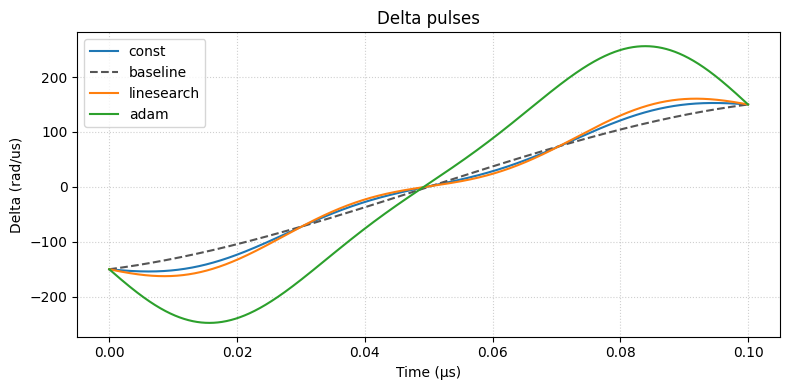

In [14]:
# Detuning pulses overlay
fig_delta, ax_delta = plt.subplots(figsize=(8, 4))
plot_pulse_overlay(summary_list, channel='delta', ax=ax_delta, labels=labels)
save_figure(fig_delta, fig_dir, 'delta_pulses', save_svg=True)


Legacy exporter removed — use the figures generated in the previous cell.

## Publication-ready figures

The cells below replicate the report-ready convergence and runtime figures
without replacing the quick-look plots earlier in the notebook.

Saved publication-ready convergence figure to /home/yehon/projects/grape-crab-qoc/results/results/step_size_convergence.png and /home/yehon/projects/grape-crab-qoc/results/results/step_size_convergence.pdf


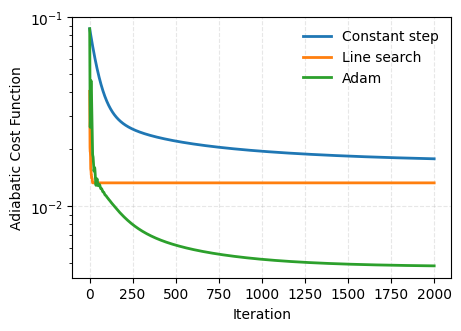

In [34]:
if not results:
    raise RuntimeError("Run the optimizer cell first.")

labels = [m for m in RUN_METHODS if m in results]
summary_lookup = {m: results[m] for m in labels}
if not summary_lookup:
    raise RuntimeError("No optimization summaries available for plotting.")

BASE_DIR = Path('/home/yehon/projects/grape-crab-qoc')
RESULT_DIRS = {
    'CMA-ES': BASE_DIR / 'notebooks' / 'results' / 'CMA-ES',
    'GRAPE': BASE_DIR / 'notebooks' / 'results' / 'GRAPE',
}
OUTPUT_DIR = BASE_DIR / 'results' / 'results'
fig_dir=OUTPUT_DIR

friendly_labels = {
    "const": "Constant step",
    "linesearch": "Line search",
    "adam": "Adam",
}
color_map = {
    "const": "#1f77b4",
    "linesearch": "#ff7f0e",
    "adam": "#2ca02c",
}

panel_specs = [
    ("Constant vs line-search vs Adam: cost convergence", ("const", "linesearch", "adam")),
]

# Create figure/axes (supports 1+ panels)
n_panels = len(panel_specs)
fig, axes = plt.subplots(
    1, n_panels,
    figsize=(4.5, 3.2),
    constrained_layout=True,
    squeeze=False
)
axes = axes[0]  # flatten row

# Plot each panel
for ax, (title, methods) in zip(axes if n_panels > 1 else [axes[0]], panel_specs):
    plotted_any = False
    for method in methods:
        summary = summary_lookup.get(method)
        if summary is None:
            continue

        # Pull history safely
        hist = getattr(getattr(summary, "history", None), "total", None)
        if hist is None:
            continue
        hist = np.asarray(hist, dtype=float)
        if hist.size == 0:
            continue

        # Iteration indices (fallback to 1..N if not provided or mismatched)
        iters = getattr(getattr(summary, "history", None), "iterations", None)
        iters = np.asarray(iters, dtype=int) if iters is not None else None
        if iters is None or iters.size != hist.size:
            iters = np.arange(1, hist.size + 1, dtype=np.int64)

        # Clamp to positive for log scale
        y = np.clip(hist, 1e-12, None)

        ax.plot(
            iters, y,
            label=friendly_labels.get(method, method.title()),
            linewidth=2,
            color=color_map.get(method, "#555555"),
        )
        plotted_any = True

    if plotted_any:
        ax.set_yscale("log")
        ax.set_xlabel("Iteration", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(frameon=False)
    else:
        ax.axis("off")

# Shared Y label on the first visible axis
if n_panels >= 1:
    axes[0].set_ylabel("Adiabatic Cost Function", fontsize=10)

# Save
convergence_png = fig_dir / "step_size_convergence.png"
convergence_pdf = fig_dir / "step_size_convergence.pdf"
fig.savefig(convergence_png, dpi=300, bbox_inches="tight")
fig.savefig(convergence_pdf, bbox_inches="tight")
print(f"Saved publication-ready convergence figure to {convergence_png} and {convergence_pdf}")


Saved runtime comparison figure to /home/yehon/projects/grape-crab-qoc/results/results/step_size_runtime.png and /home/yehon/projects/grape-crab-qoc/results/results/step_size_runtime.pdf


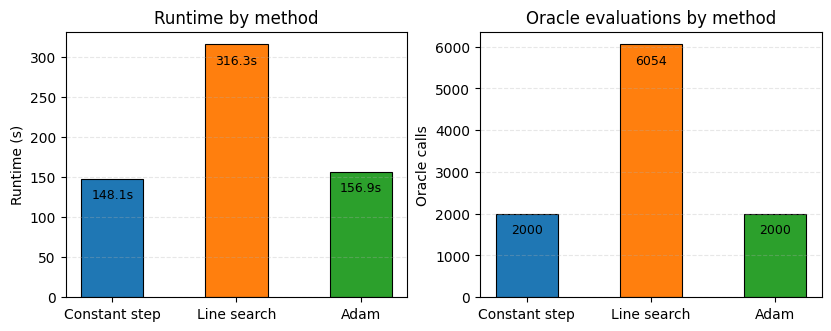

In [35]:
# Publication-ready runtime and oracle comparison
if not results:
    raise RuntimeError('Run the optimizer cell first.')

labels = [method for method in RUN_METHODS if method in results]
summary_lookup = {label: results[label] for label in labels}
if not summary_lookup:
    raise RuntimeError('No optimization summaries available for plotting.')

# fig_dir = (Path(artifact_root) / run_name / 'figures').resolve()
# fig_dir.mkdir(parents=True, exist_ok=True)

ordered_methods = [method for method in ('const', 'linesearch', 'adam') if method in summary_lookup]
if not ordered_methods:
    raise RuntimeError('No recognized step-size methods found in results.')

friendly_labels = {
    'const': 'Constant step',
    'linesearch': 'Line search',
    'adam': 'Adam',
}
color_map = {
    'const': '#1f77b4',
    'linesearch': '#ff7f0e',
    'adam': '#2ca02c',
}

x = np.arange(len(ordered_methods))
colors = [color_map.get(method, '#555555') for method in ordered_methods]
tick_labels = [friendly_labels.get(method, method.title()) for method in ordered_methods]

fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), constrained_layout=True)

metrics = (
    ('Runtime (s)', np.asarray([summary_lookup[m].runtime_s for m in ordered_methods], dtype=float), 'Runtime by method'),
    ('Oracle calls', np.asarray([summary_lookup[m].oracle_calls for m in ordered_methods], dtype=float), 'Oracle evaluations by method'),
)

for ax, (ylabel, values, title) in zip(axes, metrics):
    bars = ax.bar(x, values, width=0.5, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(axis='y', linestyle='--', alpha=0.3)
    if np.all(np.isnan(values)):
        continue
    offset = -0.09 * max(1.0, np.nanmax(values))
    for idx, bar in enumerate(bars):
        height = float(values[idx])
        if np.isnan(height):
            continue
        label_text = f'{height:.1f}s' if ylabel == 'Runtime (s)' else f'{int(round(height))}'
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + offset,
            label_text,
            ha='center',
            va='bottom',
            fontsize=9,
        )

runtime_png = fig_dir / 'step_size_runtime.png'
runtime_pdf = fig_dir / 'step_size_runtime.pdf'
fig.savefig(runtime_png, dpi=300, bbox_inches='tight')
fig.savefig(runtime_pdf, bbox_inches='tight')
print(f'Saved runtime comparison figure to {runtime_png} and {runtime_pdf}')

plt.show()


In [ ]:
print(dt)